## This code is based on some work from Ethan Muchnik (https://byod-global.slack.com/archives/D08LCUK1GFN/p1744918383362149). It: 1) generates a spectrogram of a .wav file, 2) sums the amplitudes across frequencies, 3) then generates the spectrogram of the amplitude trace

Important line of code from Ethan's work:
F2, T2, MAT2 = scipy.signal.spectrogram(np.sum(MAT1,axis = 0), FS2, nfft=NFFT2, noverlap=noverlap2, nperseg=nperseg2, scaling="density")


The screen resolution in inches is: 15.12x9.82


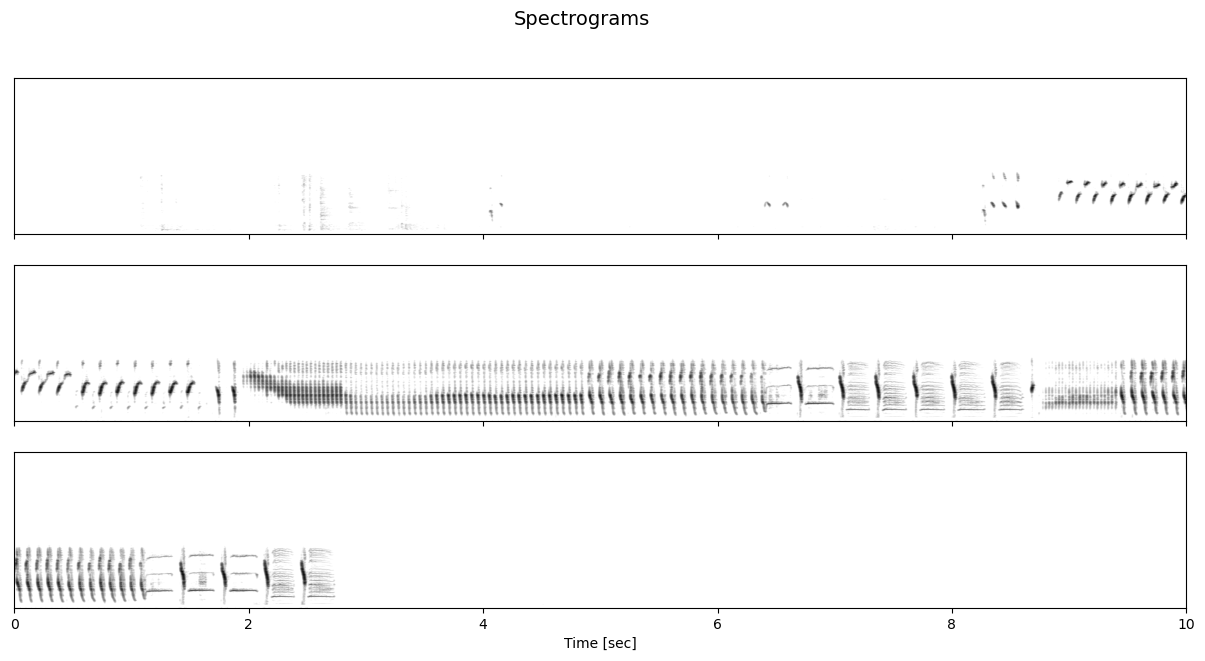

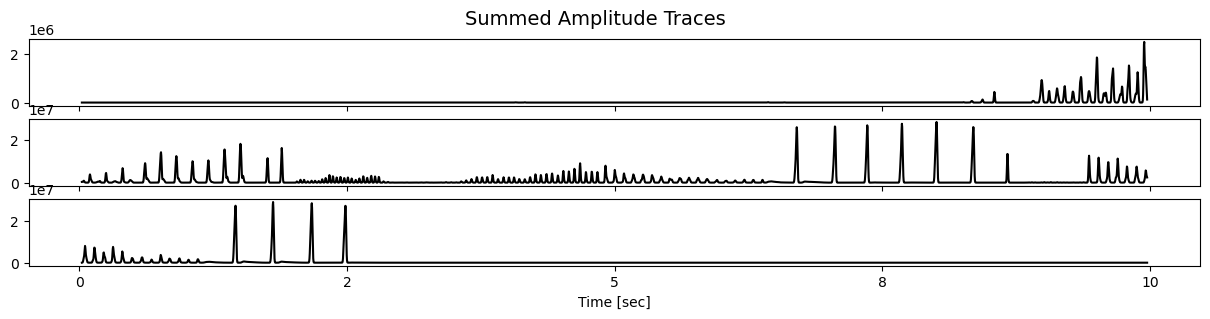

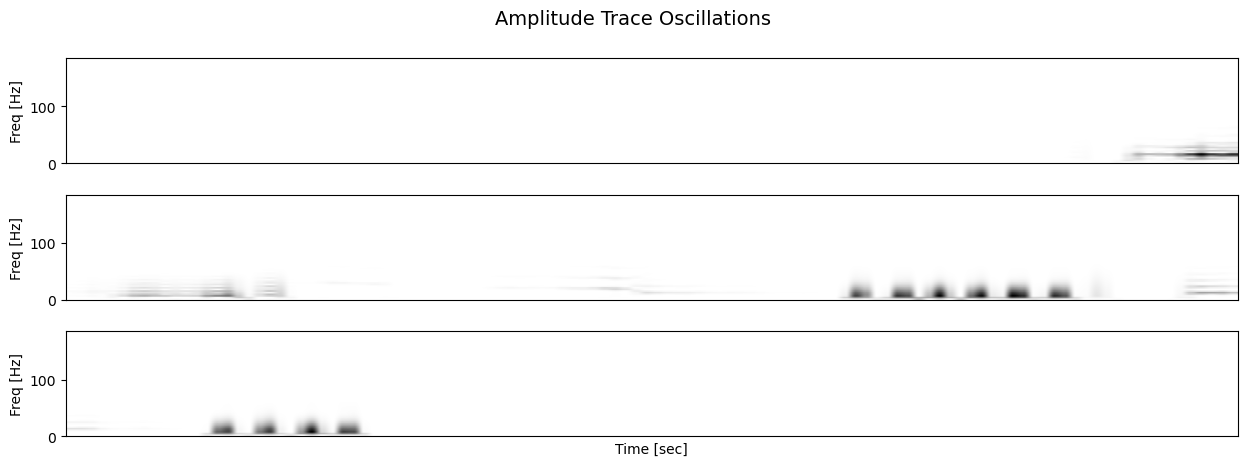

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Plot segmented spectrograms and amplitude trace oscillation ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)

            axs_sum[i].plot(t, amplitude_trace, color='black')
            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of amplitude trace ===

            # Ethan's code:
            #F2, T2, MAT2 = scipy.signal.spectrogram(np.sum(MAT1,axis = 0), FS2, nfft=NFFT2, noverlap=noverlap2, nperseg=nperseg2, scaling="density")
            amp_fs = len(t) / segment_duration  # estimated sample rate of amplitude trace
            f_amp, t_amp, Sxx_amp = spectrogram(
                amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                       extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                       cmap='binary')

            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle('Summed Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path)


# Take the log of the summed amplitude traces to normalize

The screen resolution in inches is: 15.12x9.82


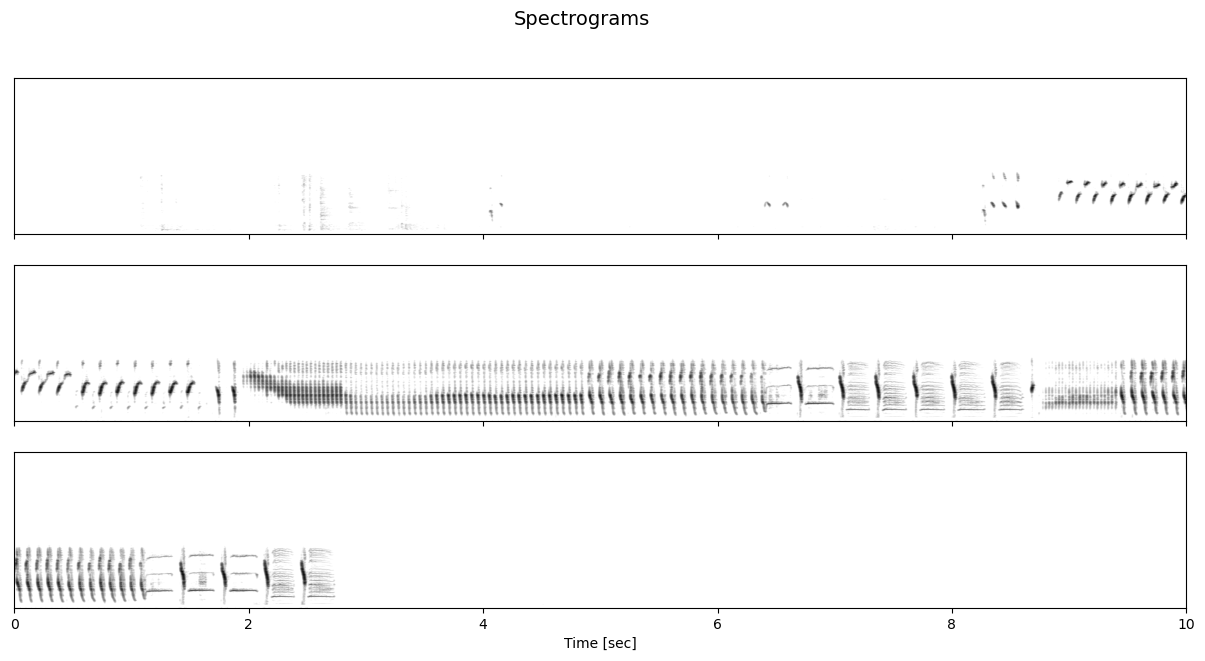

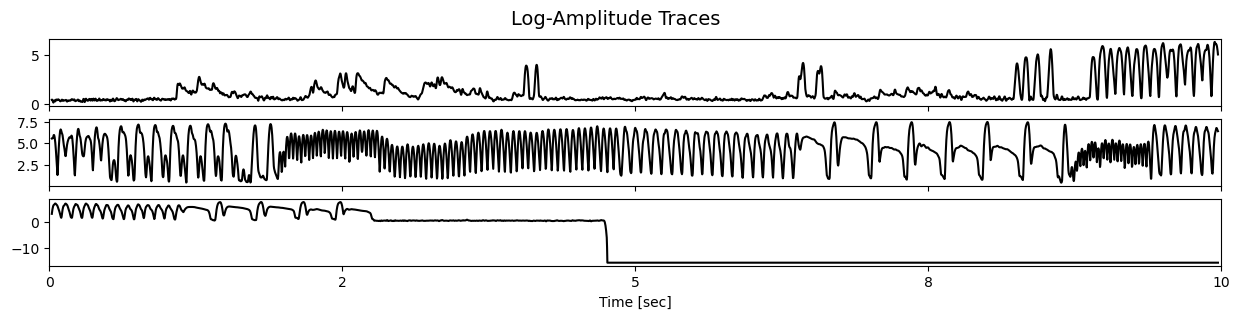

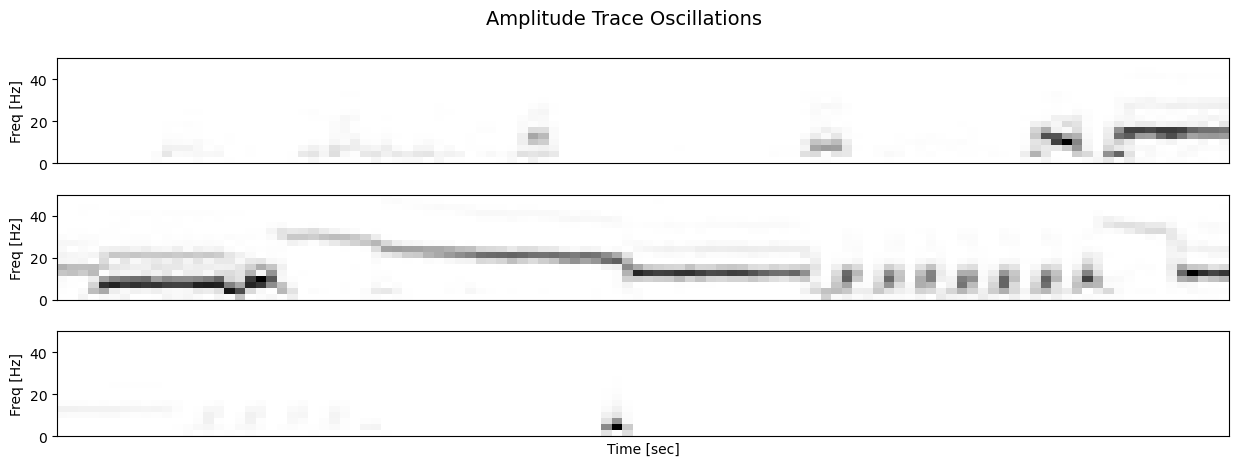

In [2]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Plot segmented spectrograms and log amplitude trace oscillation ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)  # Force x-axis to be 0–10 sec

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])


            # === Spectrogram of log-amplitude trace ===
            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration  # estimated sample rate of amplitude trace
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                                cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path)


The screen resolution in inches is: 15.12x9.82


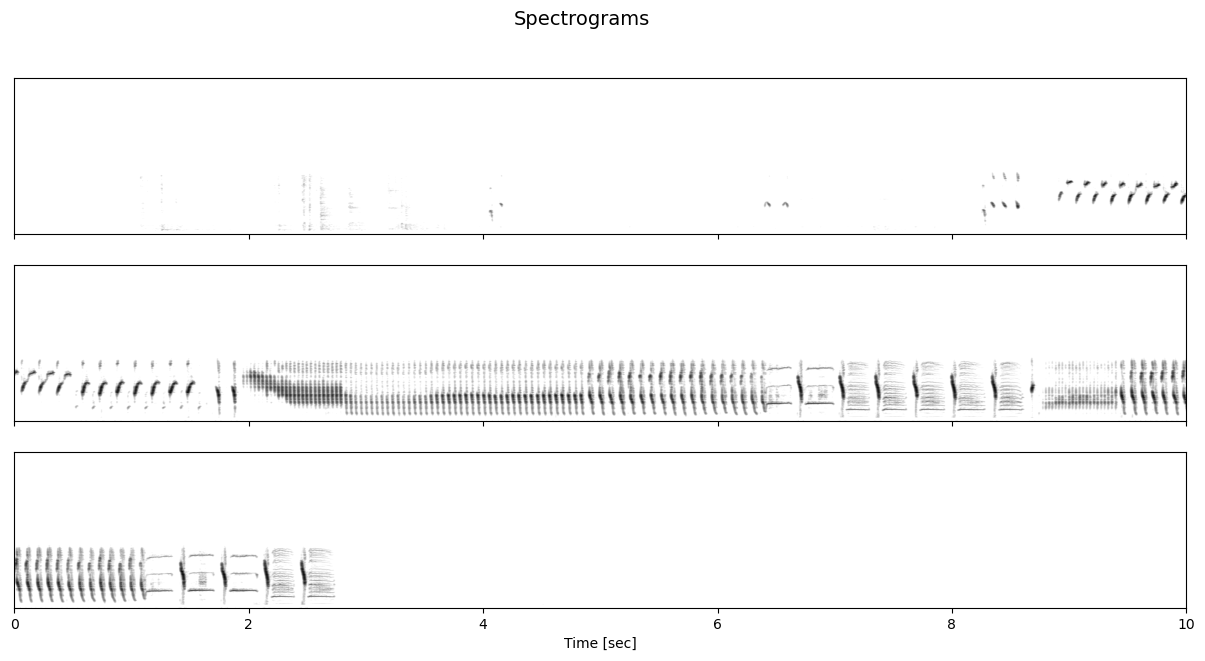

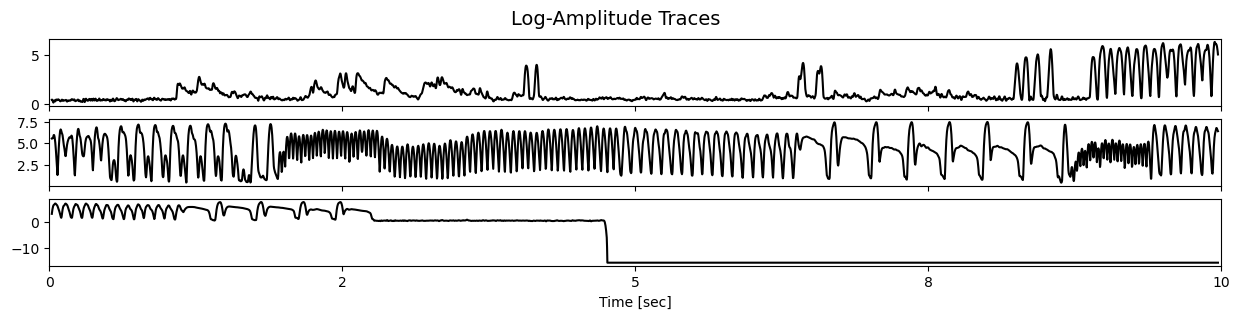

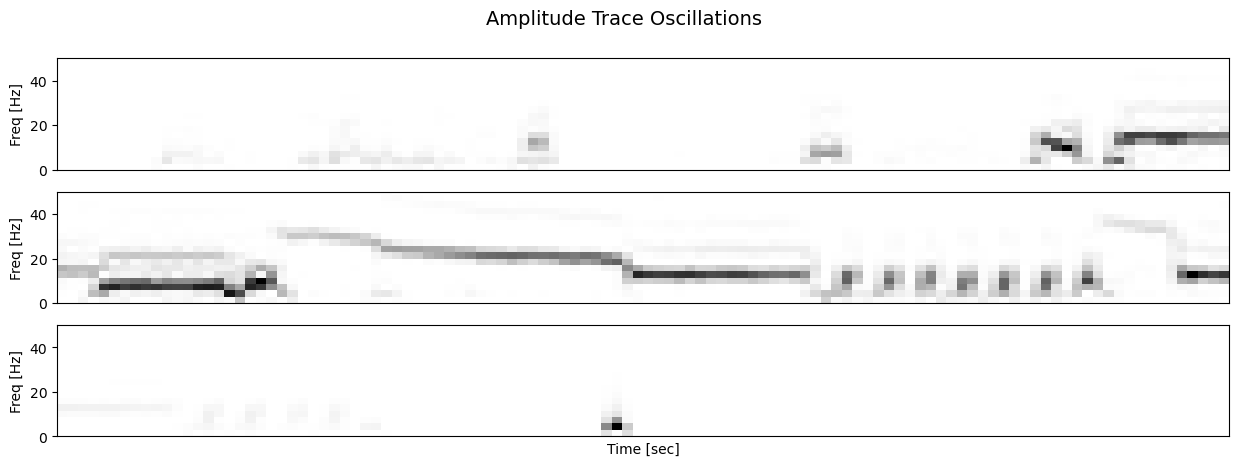

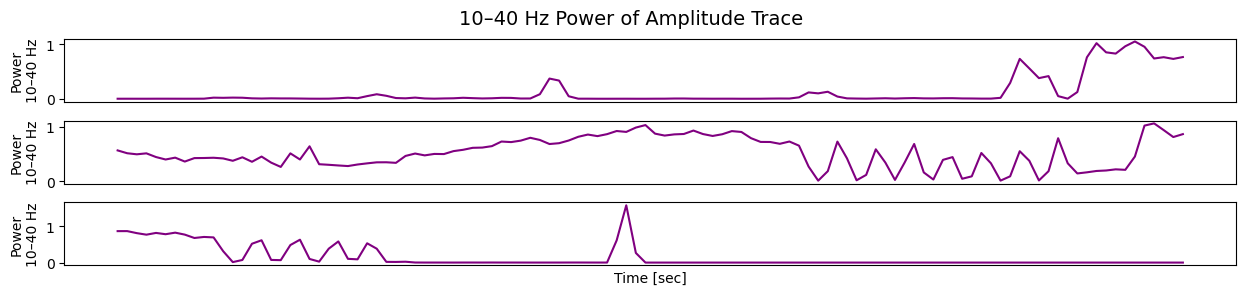

In [3]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Plot segmented spectrograms and log amplitude trace oscillation ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)  # NEW

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)  # Force x-axis to be 0–10 sec

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])


            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration  # estimated sample rate of amplitude trace
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                                cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

            # === NEW: Sum amplitude trace oscillation between 10-40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')
            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
            else:
                axs_power_band[i].set_xticks([])

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path)


The screen resolution in inches is: 15.12x9.82


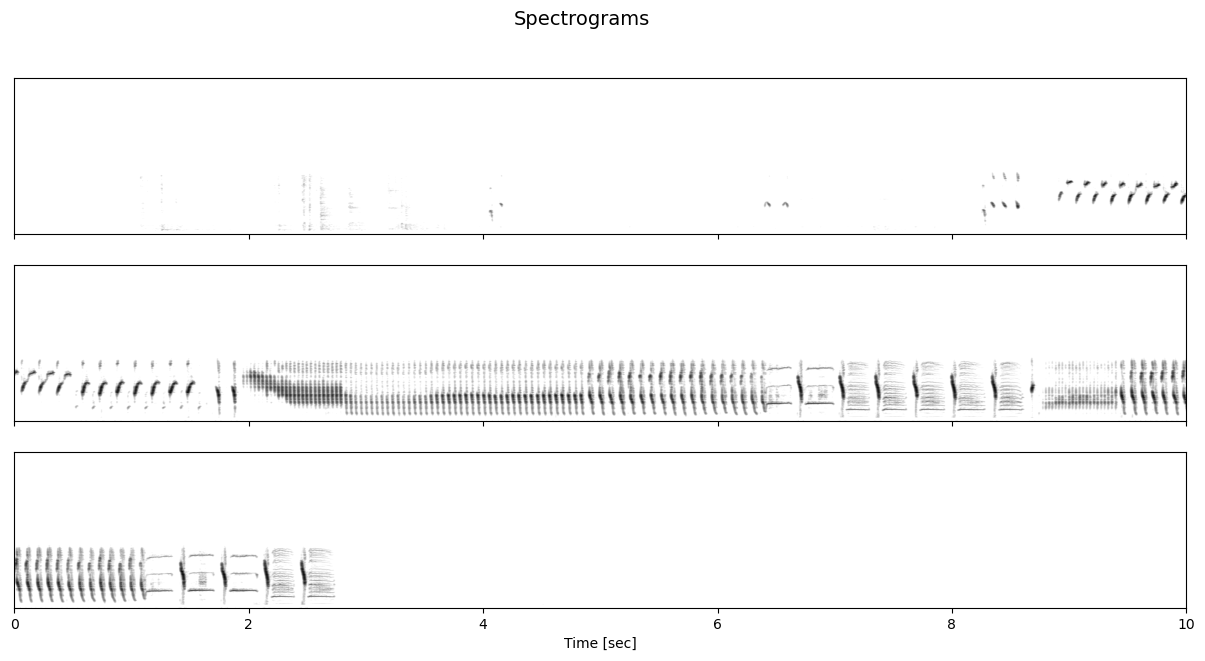

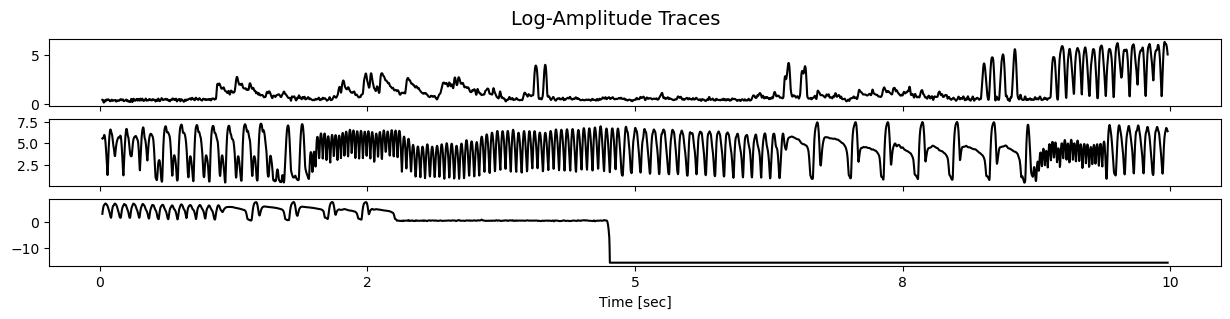

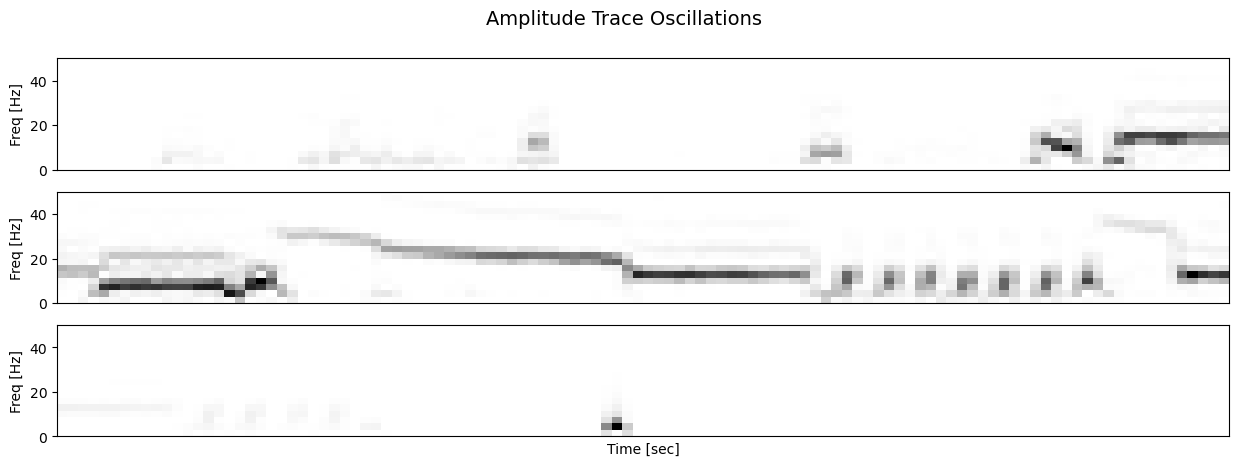

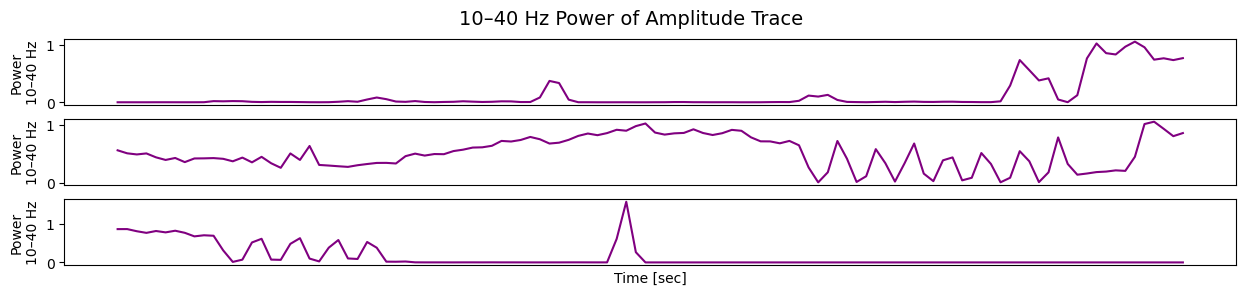

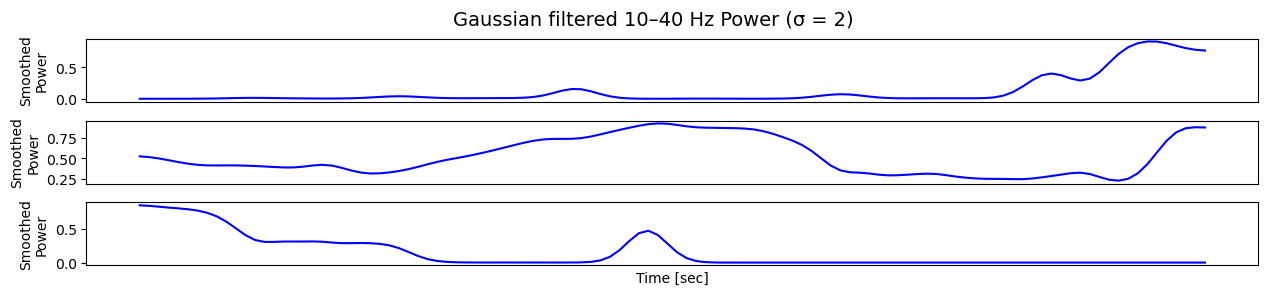

In [2]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Plot segmented spectrograms and log amplitude trace oscillation ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000, smoothing_sigma=2):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)  # NEW

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration  # estimated sample rate of amplitude trace
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                                cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power trace in 10-40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')
            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
            else:
                axs_power_band[i].set_xticks([])

            # === NEW: Gaussian-smoothed power ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')
            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Gaussian filtered 10–40 Hz Power (σ = {smoothing_sigma})', fontsize=14)
        plt.show()


    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path)


The screen resolution in inches is: 15.12x9.82


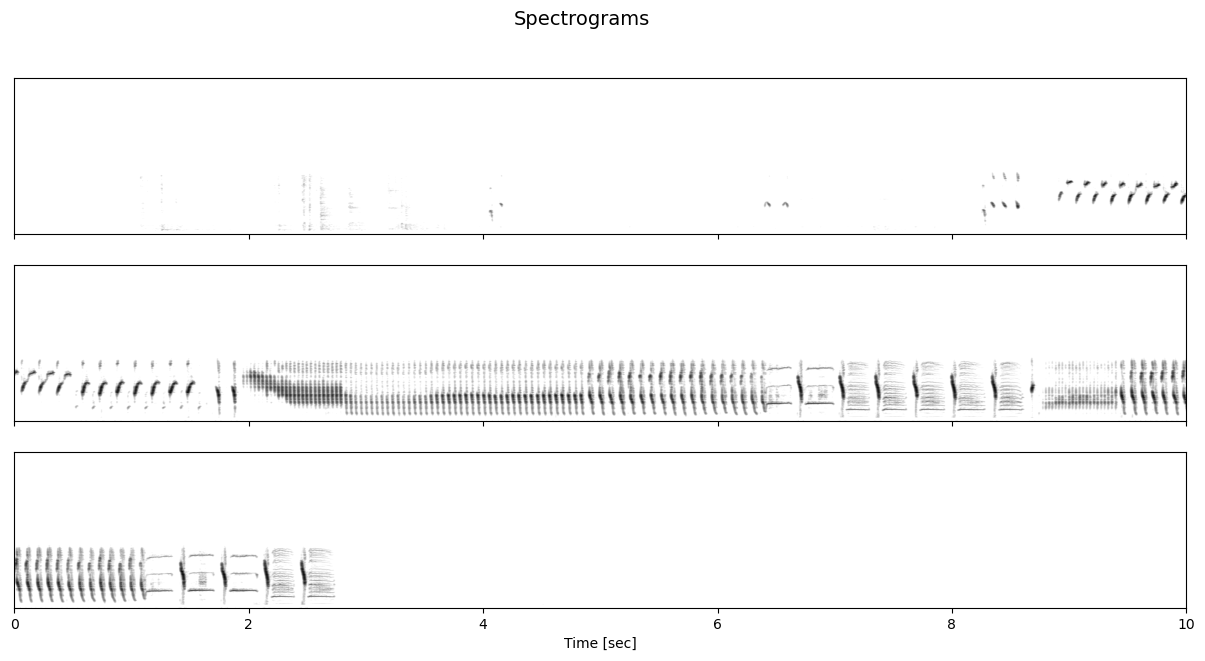

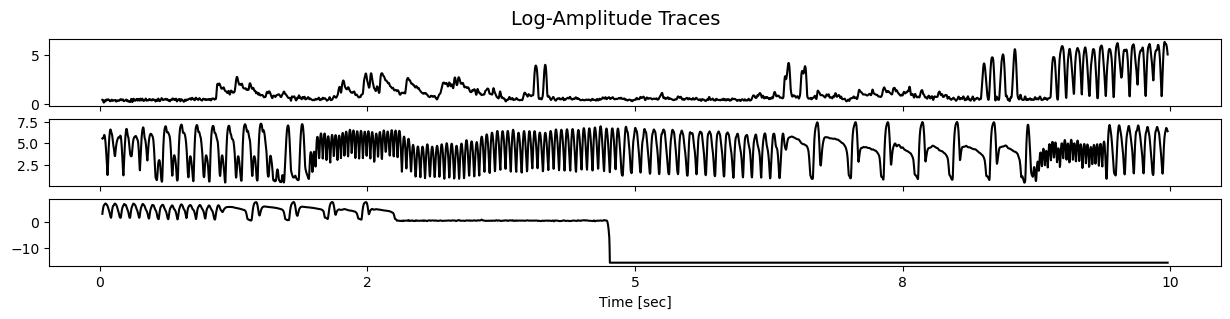

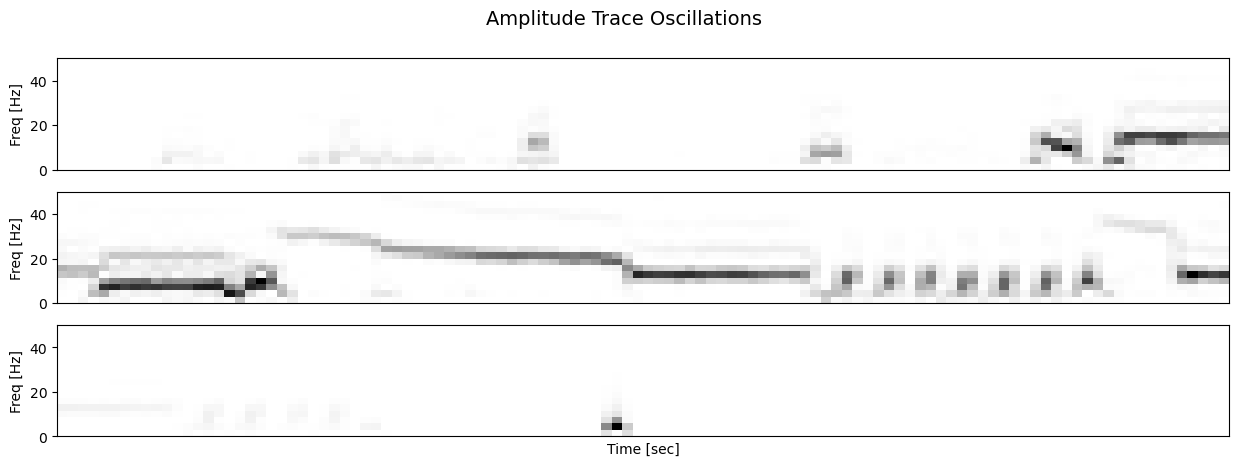

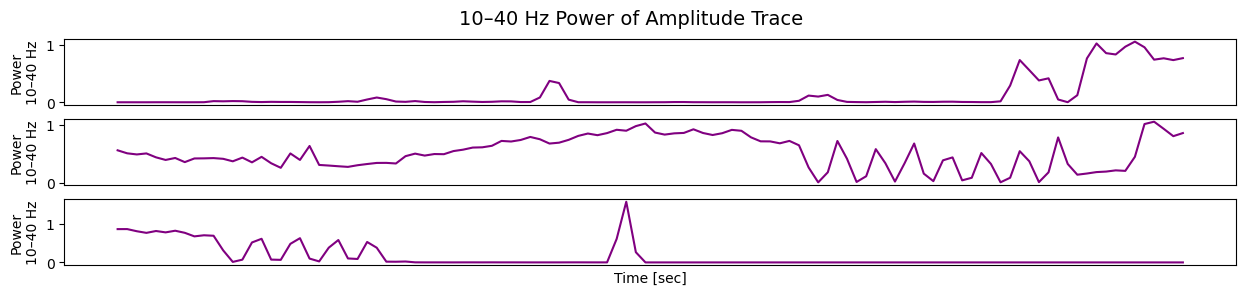

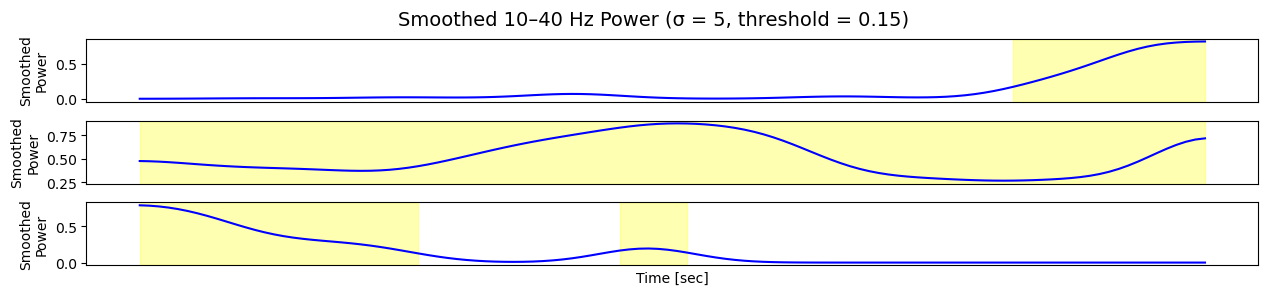

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119) #119 = step size, 119 sample size 119/44100 = 2.7 ms, we'll lose 64  each 2.7
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128, #nfft in matlab
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power trace in 10–40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')
            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed 10–40 Hz Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            # Highlight detected song
            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=5, power_threshold=0.15)


The screen resolution in inches is: 15.12x9.82


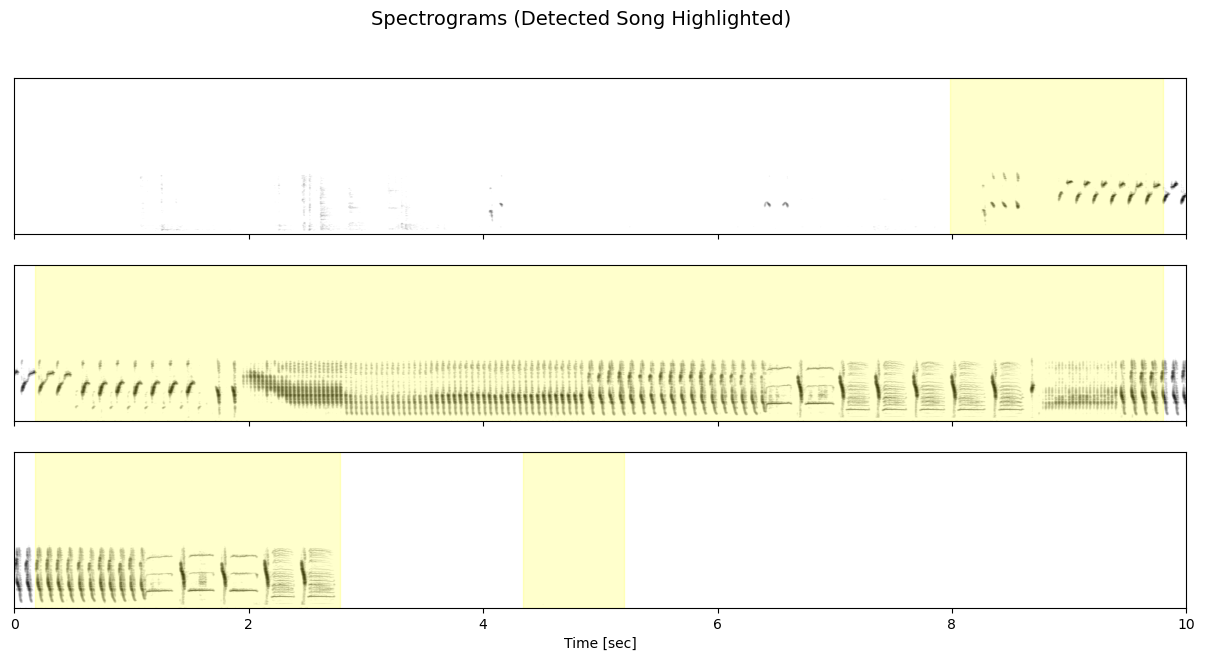

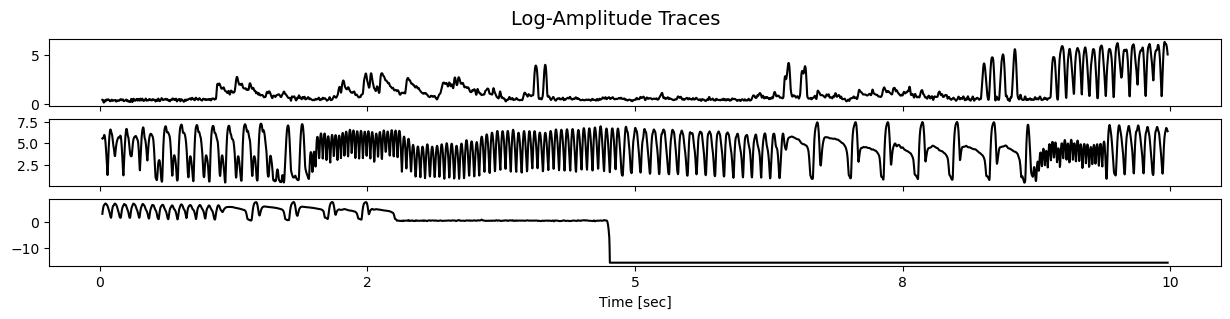

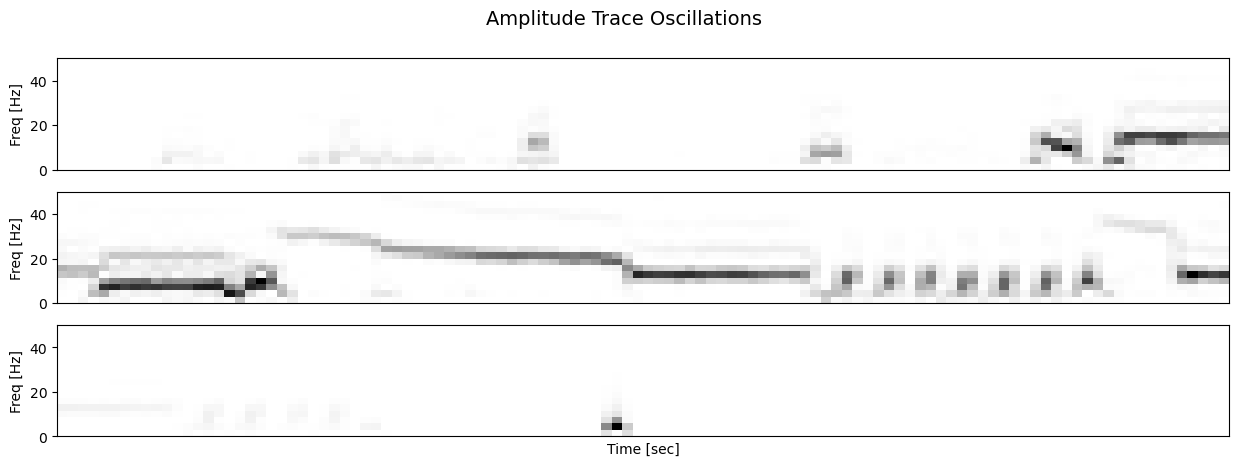

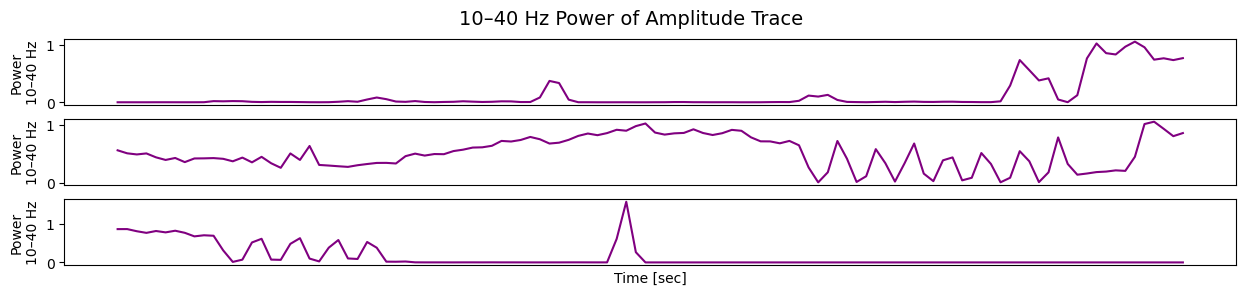

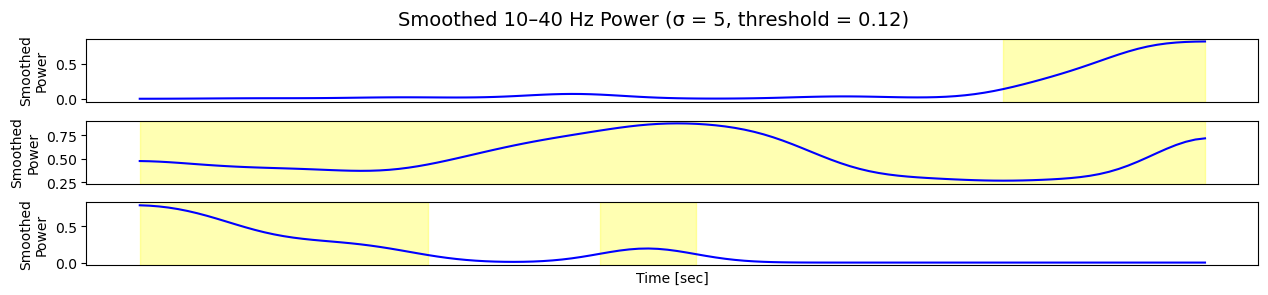

In [6]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power trace in 10–40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')
            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed 10–40 Hz Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            # Highlight detected song on smoothed and original spectrogram
            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=5, power_threshold=0.12)


# Fixing the misalignment in x axes

The screen resolution in inches is: 15.12x9.82


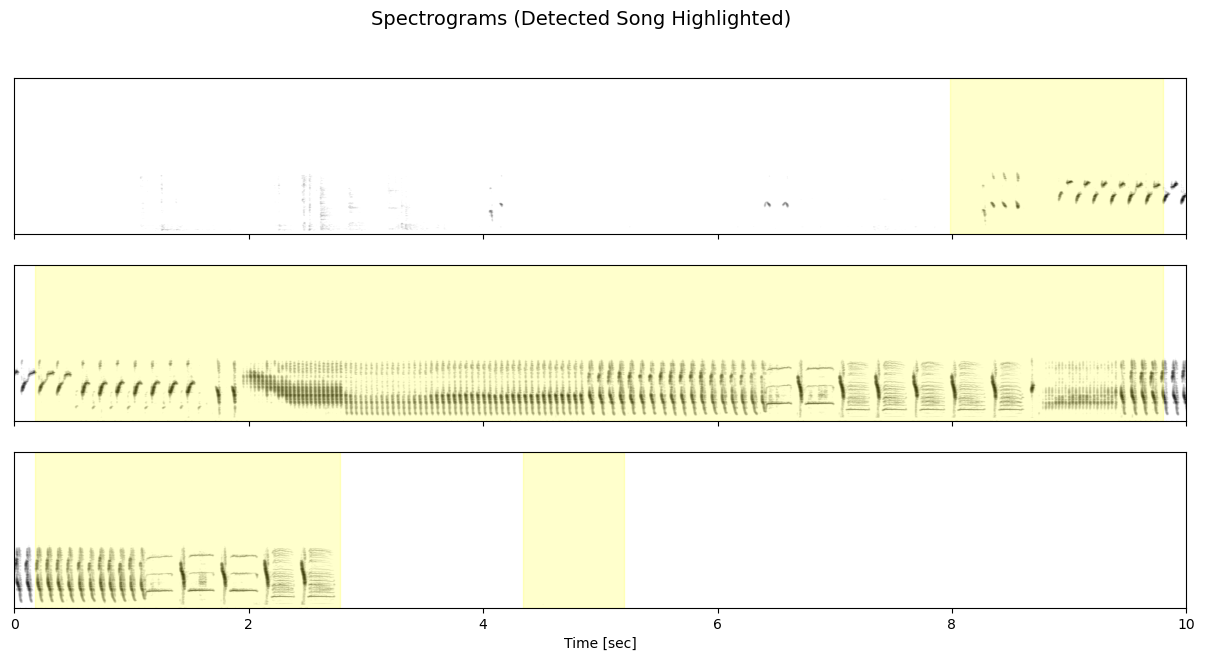

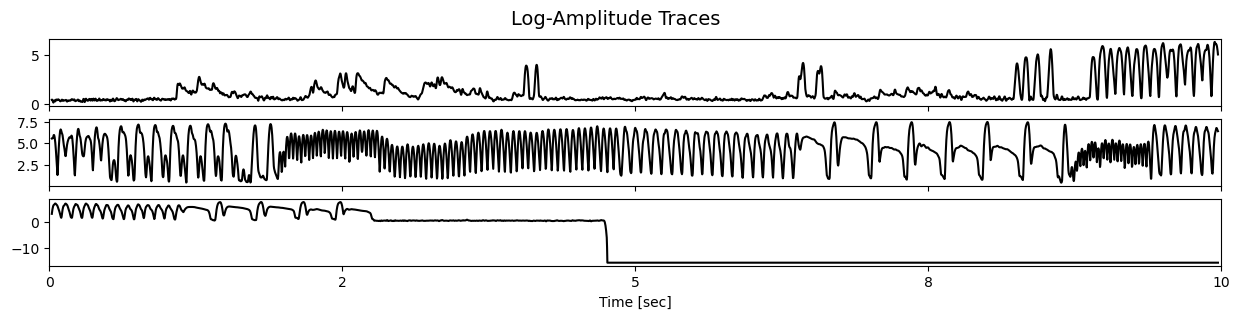

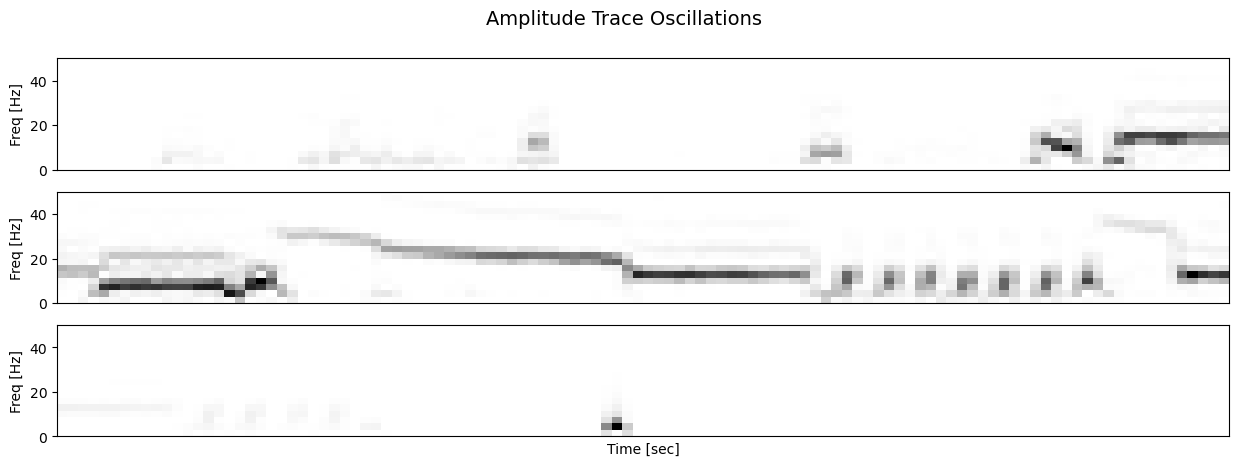

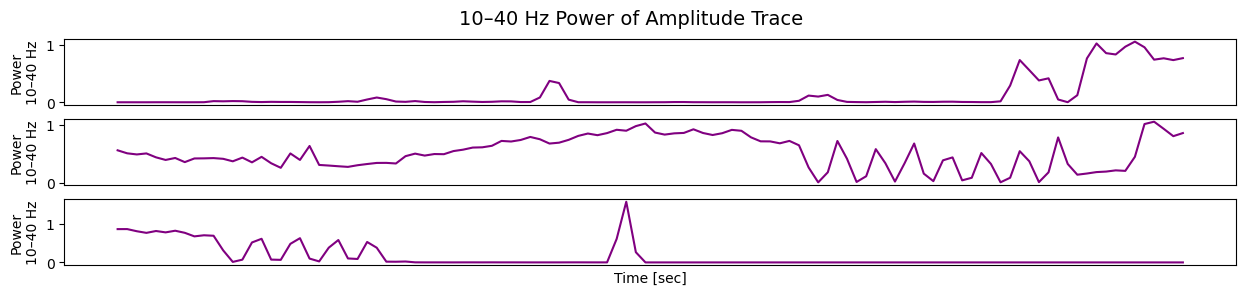

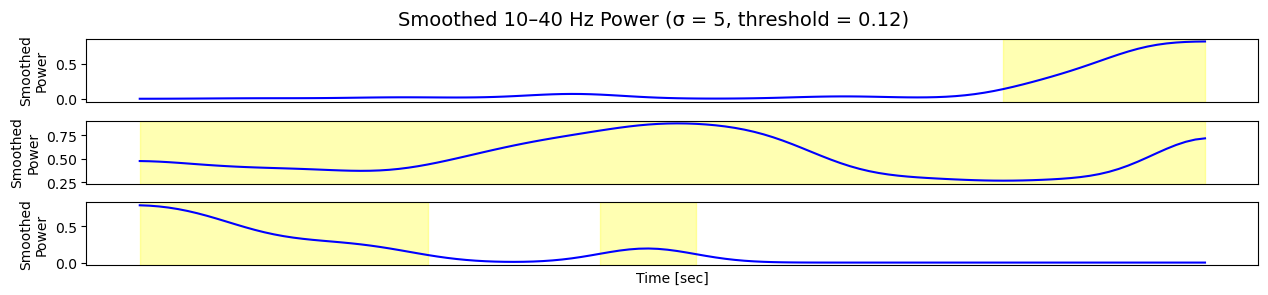

In [7]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)  # Force x-axis to be 0–10 sec

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])


            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[0, segment_duration, f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power trace in 10–40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')
            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed 10–40 Hz Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            # Highlight detected song on smoothed and original spectrogram
            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=5, power_threshold=0.12)


The screen resolution in inches is: 15.12x9.82


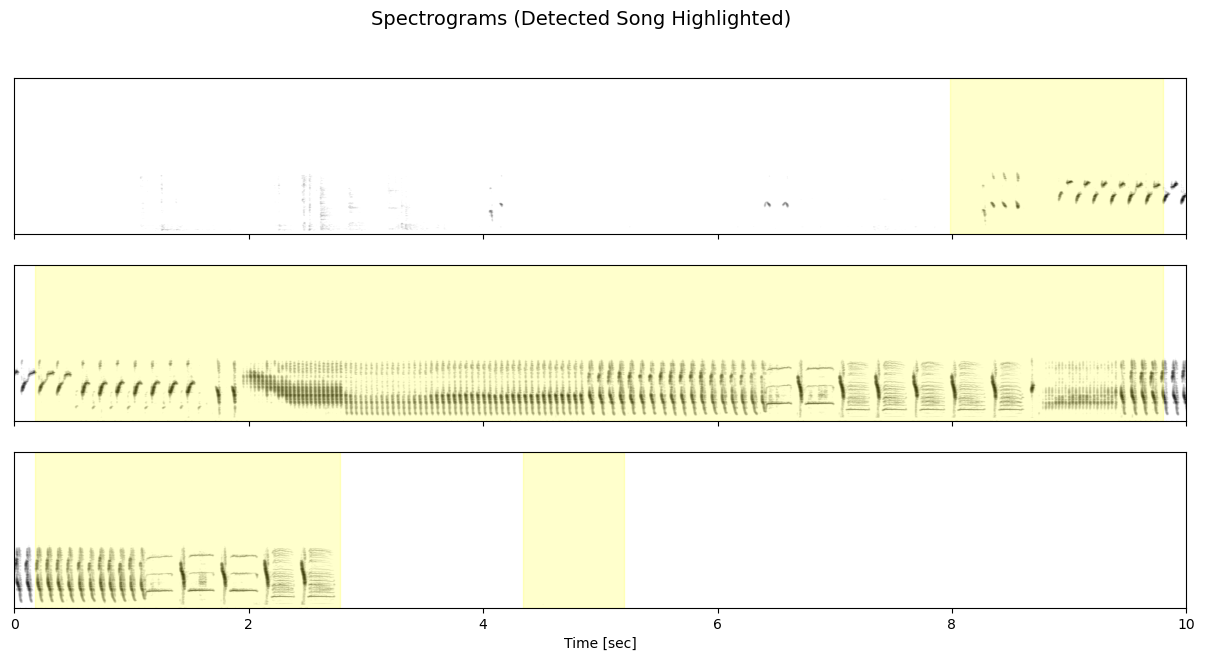

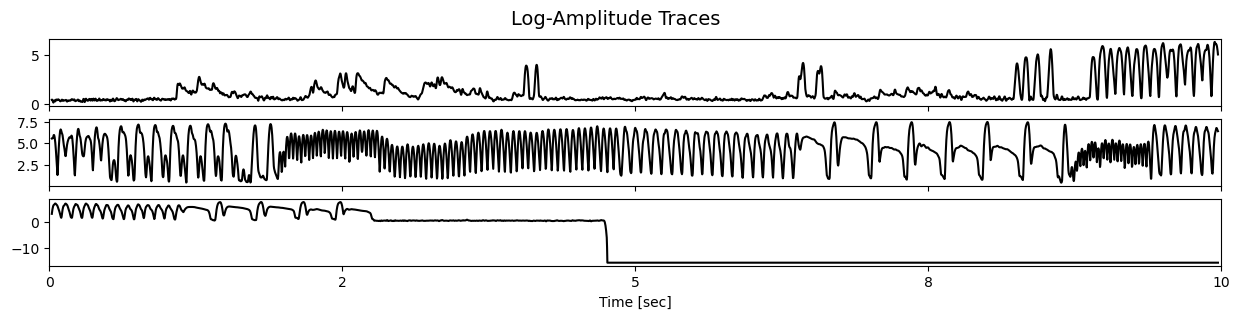

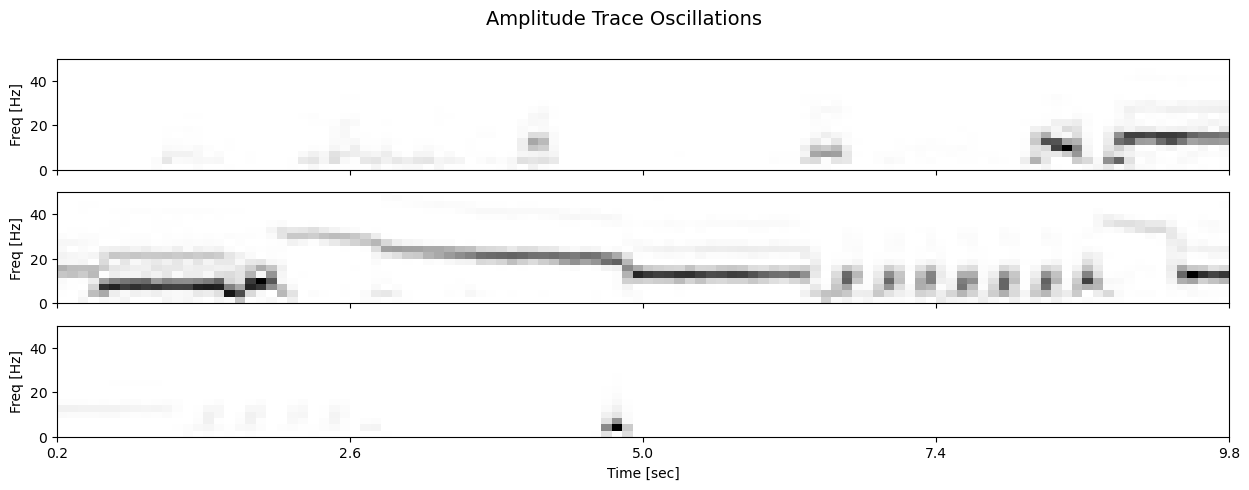

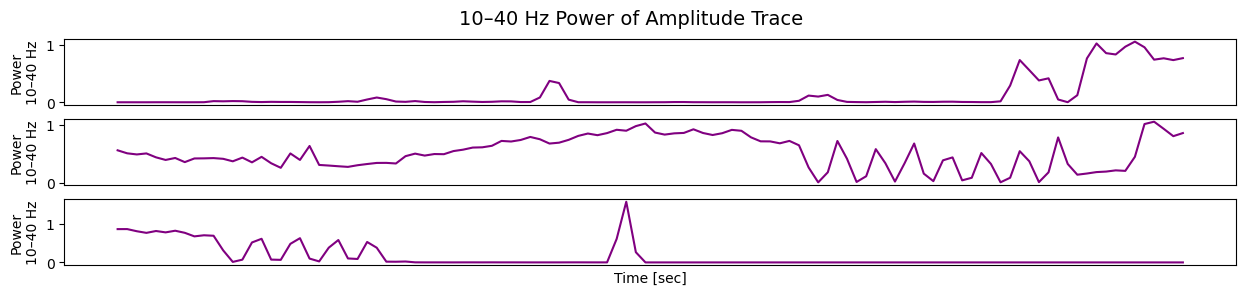

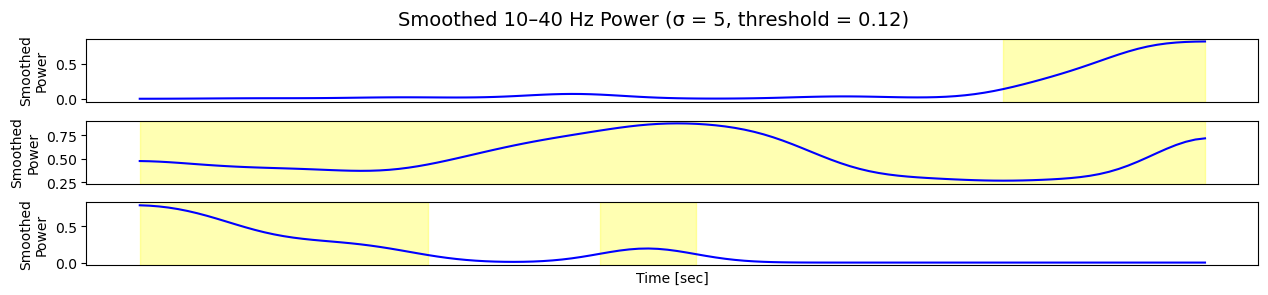

In [8]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[t_amp.min(), t_amp.max(), f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_xlim(t_amp.min(), t_amp.max())
            axs_amp_spec[i].set_ylabel('Freq [Hz]')

            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_amp_spec[i].set_xticks(tick_positions)
                axs_amp_spec[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power trace in 10–40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')
            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed 10–40 Hz Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            # Highlight detected song on smoothed and original spectrogram
            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=5, power_threshold=0.12)


The screen resolution in inches is: 15.12x9.82


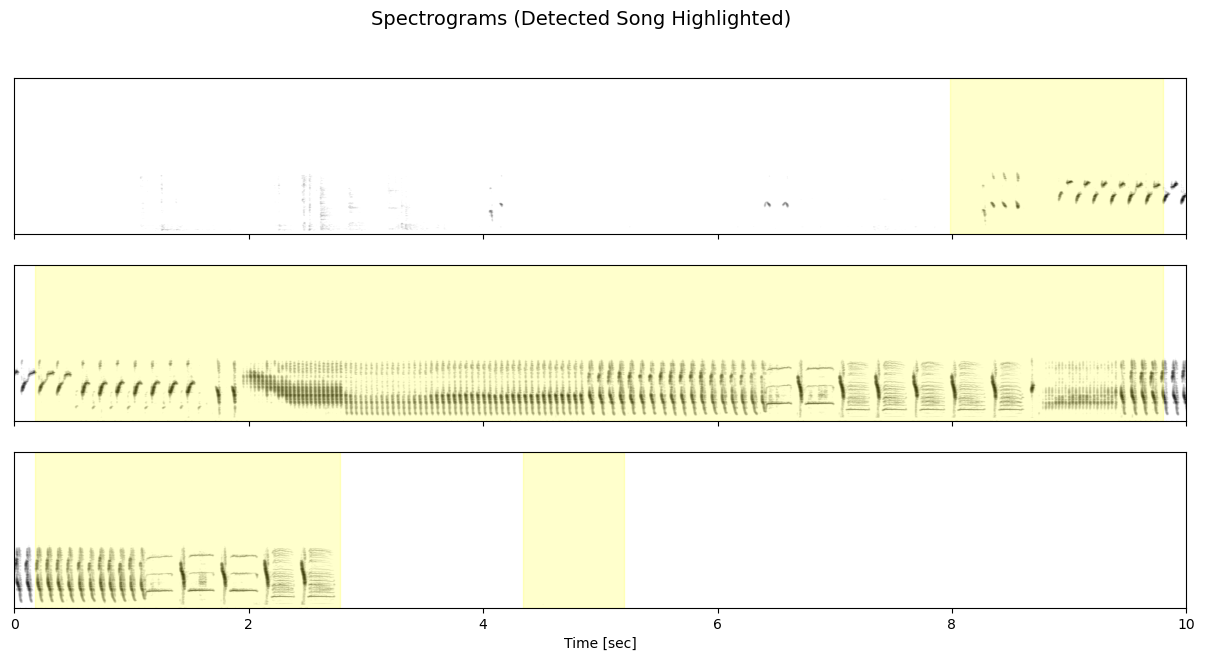

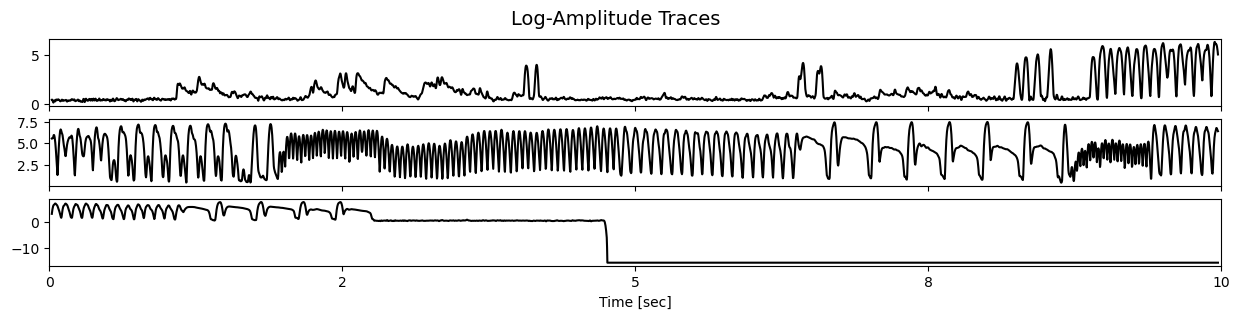

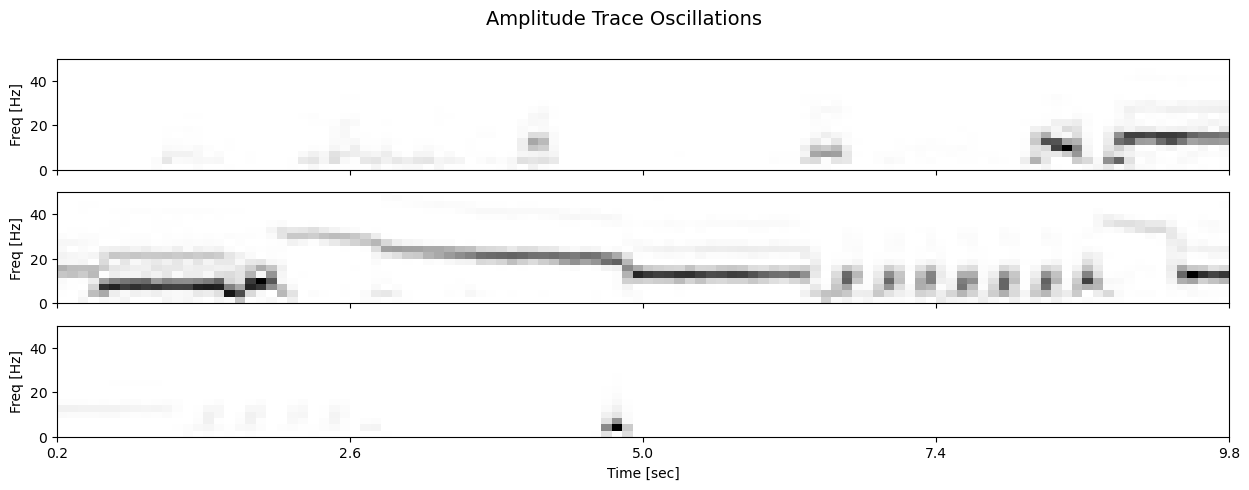

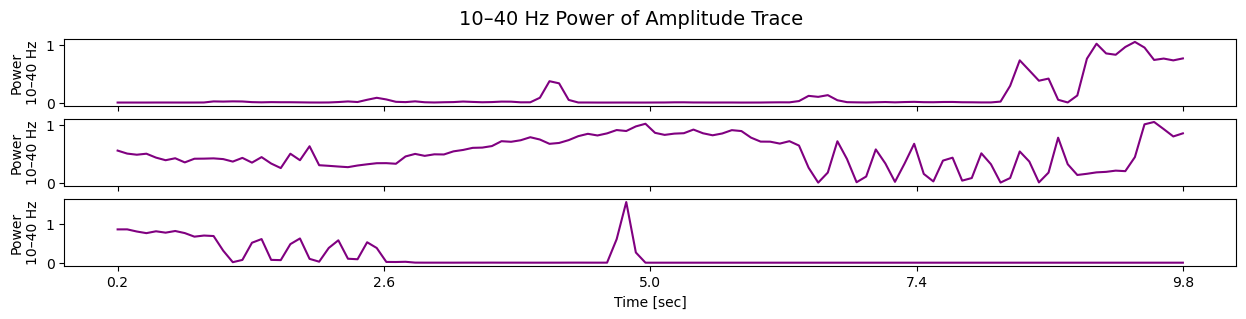

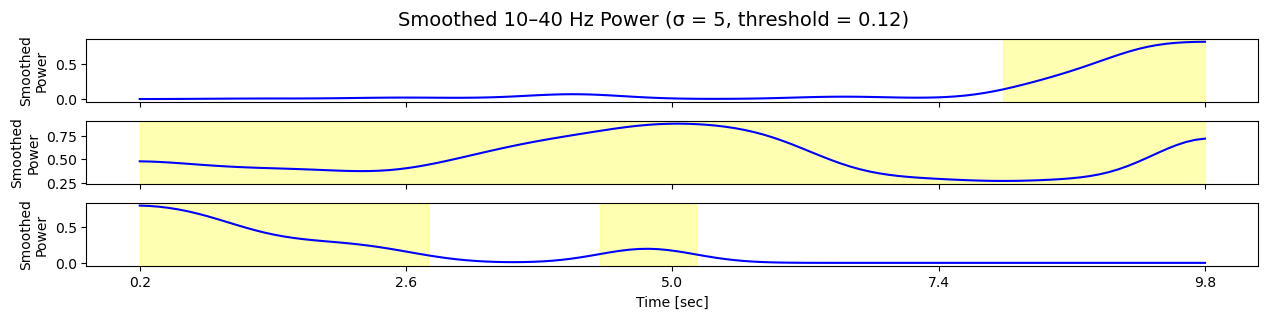

In [9]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace ===
            amp_fs = len(t) / segment_duration
            f_amp, t_amp, Sxx_amp = spectrogram(
                log_amplitude_trace,
                fs=amp_fs,
                window='hann',
                nperseg=128,
                noverlap=96
            )

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[t_amp.min(), t_amp.max(), f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_xlim(t_amp.min(), t_amp.max())
            axs_amp_spec[i].set_ylabel('Freq [Hz]')

            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_amp_spec[i].set_xticks(tick_positions)
                axs_amp_spec[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power trace in 10–40 Hz ===
            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')

            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_power_band[i].set_xticks(tick_positions)
                axs_power_band[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed 10–40 Hz Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            # Highlight detected song on smoothed and original spectrogram
            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_smoothed_power[i].set_xticks(tick_positions)
                axs_smoothed_power[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=5, power_threshold=0.12)


The screen resolution in inches is: 15.12x9.82


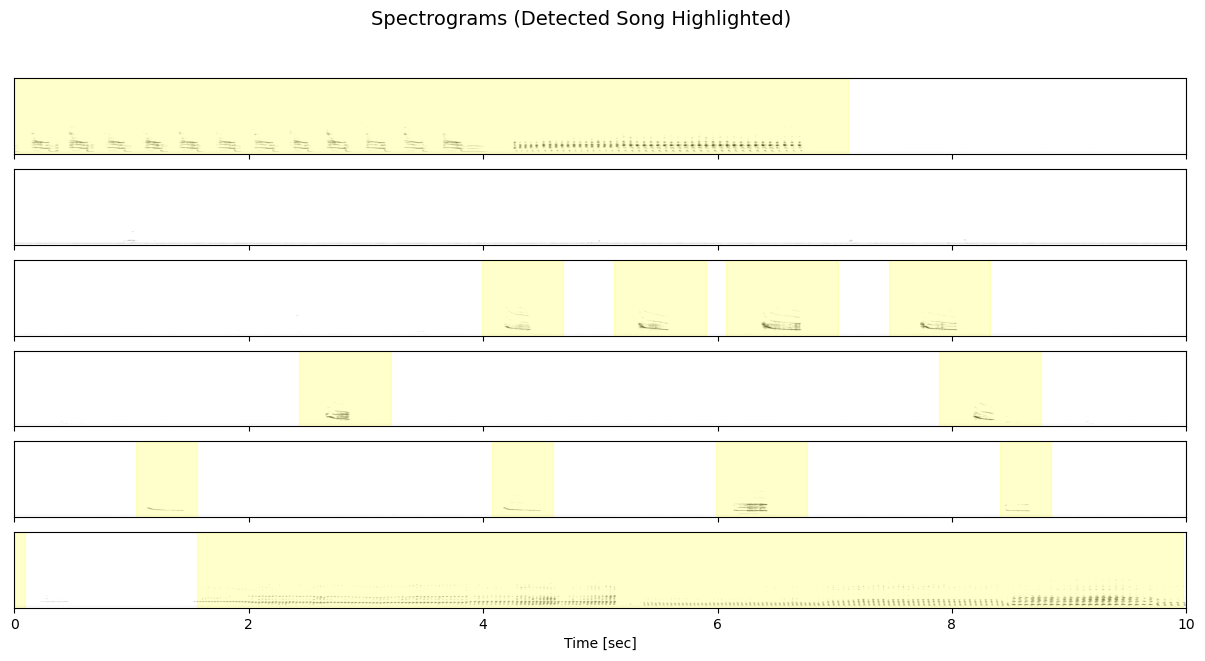

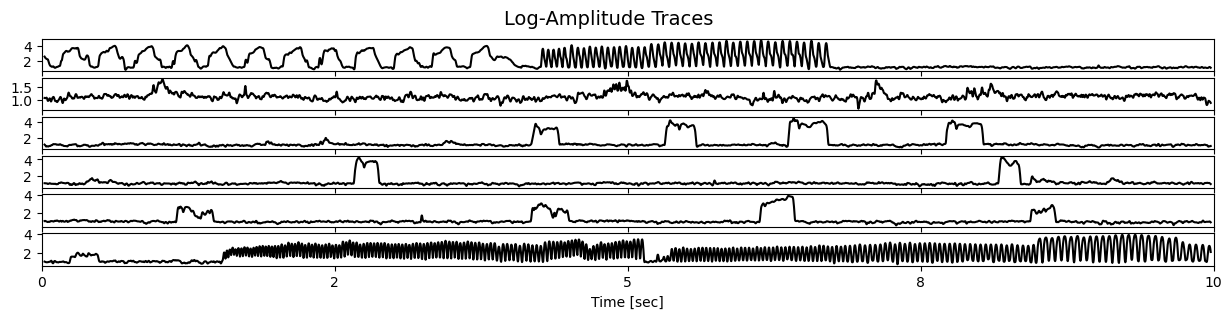

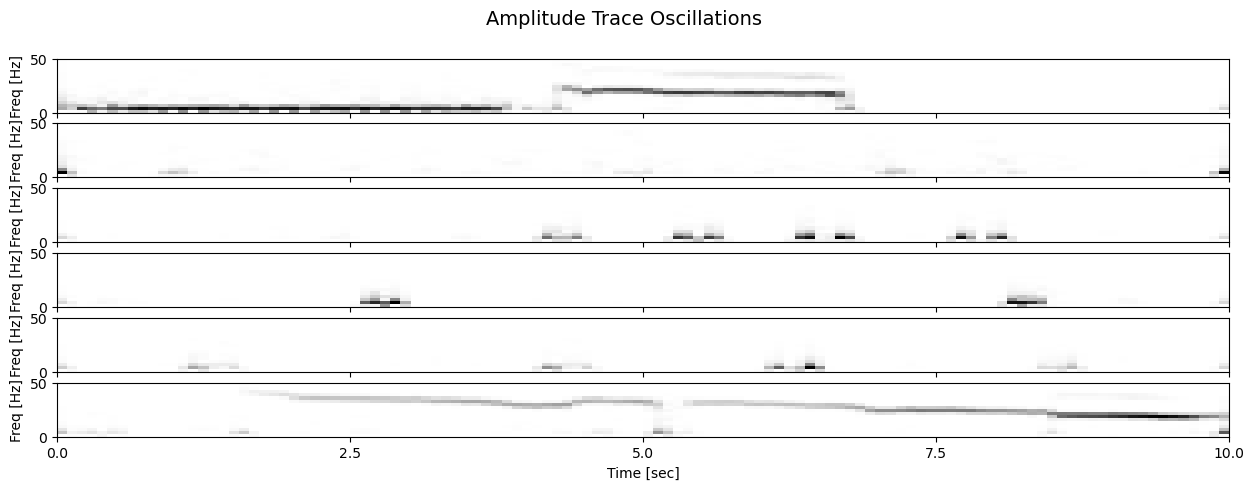

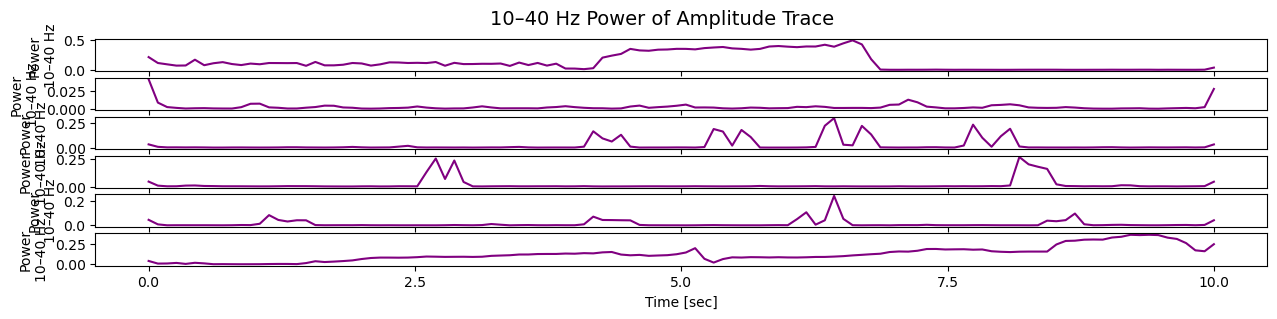

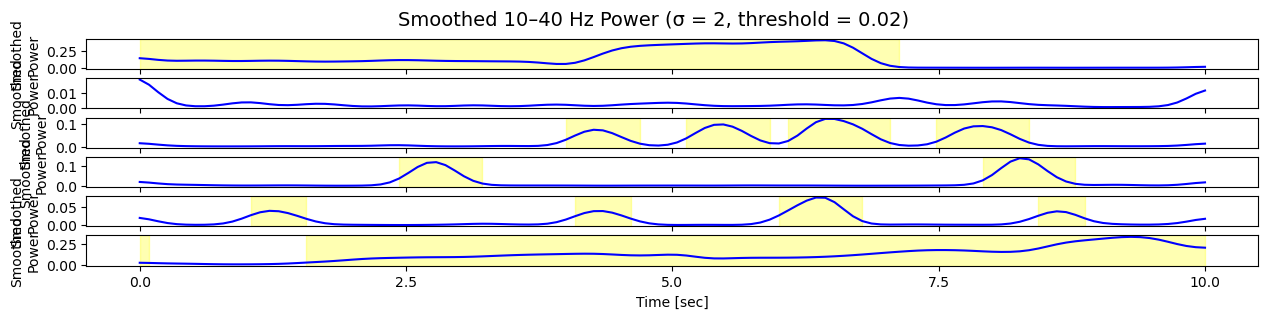

In [15]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace with full padding ===
            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            if pad_end < 0:
                pad_end = 0

            padded_log_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_log_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs  # Shift to align first window center to 0s

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[t_amp.min(), t_amp.max(), f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_xlim(t_amp.min(), t_amp.max())
            axs_amp_spec[i].set_ylabel('Freq [Hz]')

            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_amp_spec[i].set_xticks(tick_positions)
                axs_amp_spec[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_amp_spec[i].set_xticks([])

            # === Bandpassed Power trace in Hz ===
            band_mask = (f_amp >= 5) & (f_amp <= 50)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')

            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_power_band[i].set_xticks(tick_positions)
                axs_power_band[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed Bandpassed Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_smoothed_power[i].set_xticks(tick_positions)
                axs_smoothed_power[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
#file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_4.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=2, power_threshold=0.02)

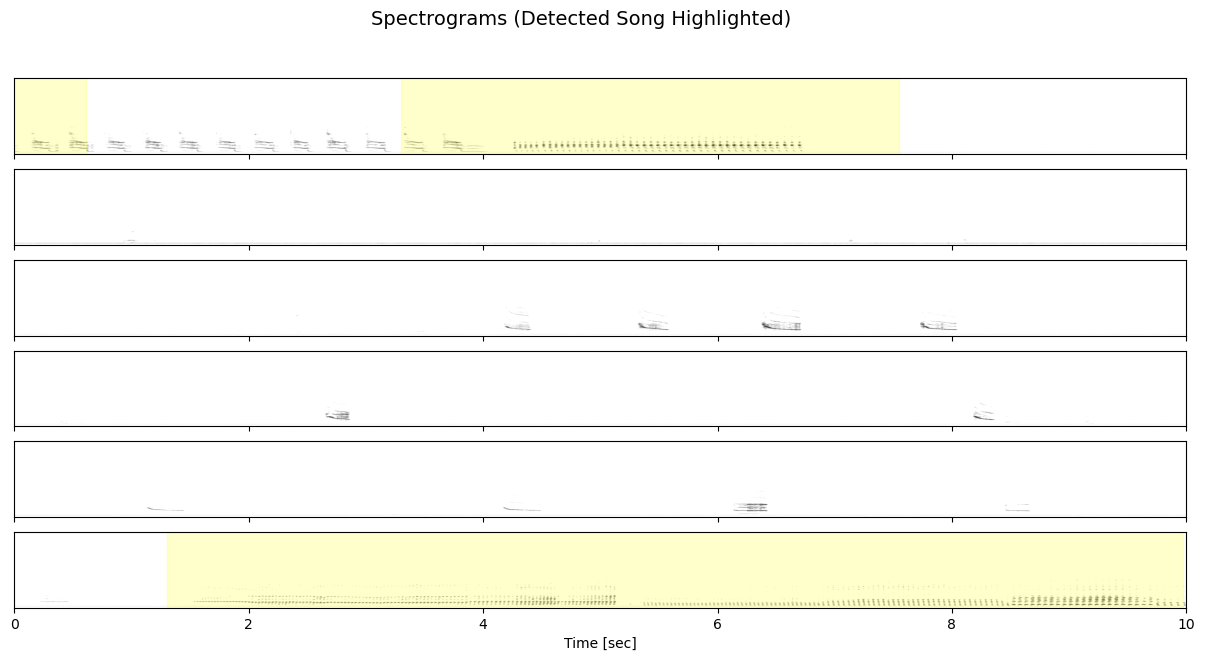

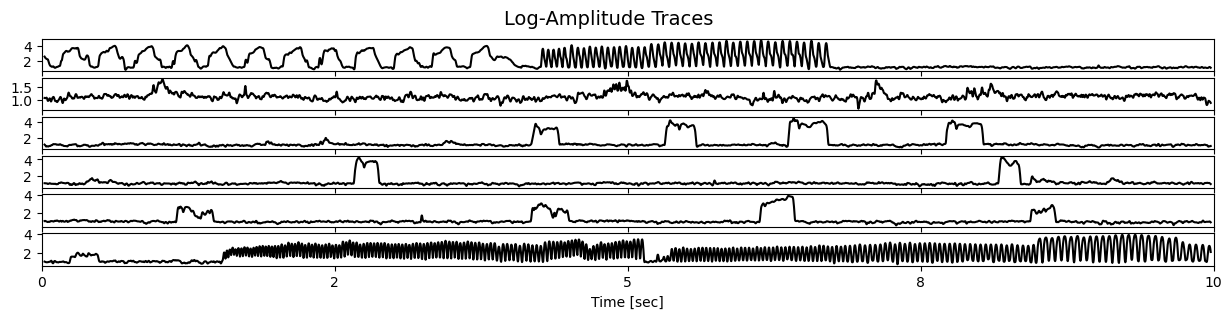

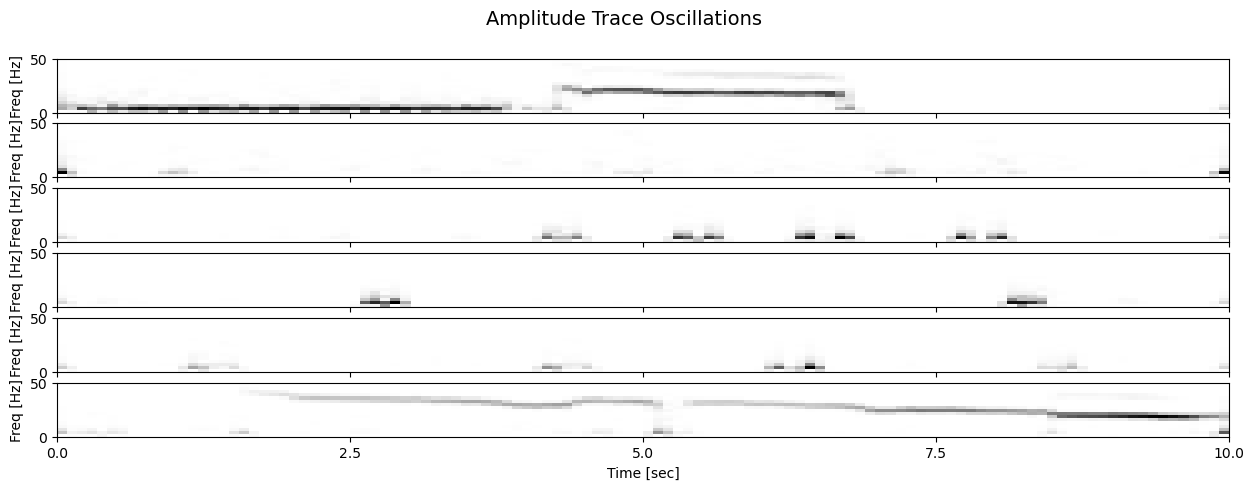

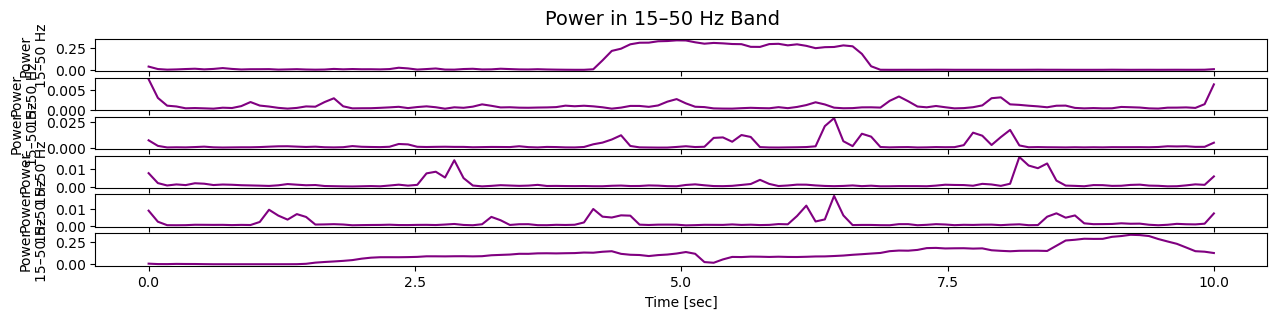

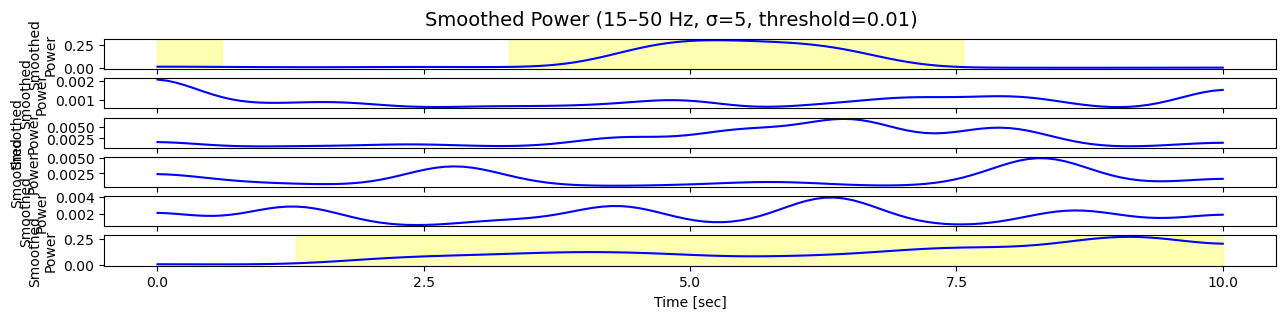

In [20]:
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5,
                                  power_band_low=10, power_band_high=40):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter on raw audio
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude Trace ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of Amplitude Trace ===
            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            pad_end = max(0, pad_end)

            padded_log_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_log_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[t_amp.min(), t_amp.max(), f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_xlim(t_amp.min(), t_amp.max())
            axs_amp_spec[i].set_ylabel('Freq [Hz]')

            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_amp_spec[i].set_xticks(tick_positions)
                axs_amp_spec[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_amp_spec[i].set_xticks([])

            # === Power in custom Hz Band ===
            band_mask = (f_amp >= power_band_low) & (f_amp <= power_band_high)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel(f'Power\n{power_band_low}–{power_band_high} Hz')

            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_power_band[i].set_xticks(tick_positions)
                axs_power_band[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed Power Trace & Highlighted Segments ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_smoothed_power[i].set_xticks(tick_positions)
                axs_smoothed_power[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_smoothed_power[i].set_xticks([])

        # === Update Titles ===
        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle(f'Power in {power_band_low}–{power_band_high} Hz Band', fontsize=14)
        fig5.suptitle(f'Smoothed Power ({power_band_low}–{power_band_high} Hz, σ={smoothing_sigma}, threshold={power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

plot_spectrograms_by_segment(
    file_path,
    smoothing_sigma=5,
    power_threshold=0.01,
    power_band_low=15,
    power_band_high=50
)

## TG edit: look for high frequency bands, if they exist, then check the lower frequencies

# Let's make some code that uses this to find segments with detected songs

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json

def detect_song_intervals(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                          smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        detected_intervals = []

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = min(start_sample + segment_length_samples, len(data))
            segment_data = data[start_sample:end_sample]

            if len(segment_data) < segment_length_samples:
                # Pad the last segment
                padded = np.zeros(segment_length_samples, dtype=segment_data.dtype)
                padded[:len(segment_data)] = segment_data
                segment_data = padded

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )

            freq_mask = (f >= low_cut) & (f <= high_cut)
            amplitude_trace = np.sum(Sxx[freq_mask, :], axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            # Pad amplitude trace for spectrogram
            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            if pad_end < 0:
                pad_end = 0
            padded_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs

            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # Detect song segments
            above_thresh = smoothed_power > power_threshold
            in_segment = False
            segment_start = 0

            for j, is_above in enumerate(above_thresh):
                current_time = t_amp[j] + i * segment_duration
                if is_above and not in_segment:
                    in_segment = True
                    segment_start = current_time
                elif not is_above and in_segment:
                    segment_end = current_time
                    detected_intervals.append([segment_start, segment_end])
                    in_segment = False

            if in_segment:
                segment_end = t_amp[-1] + i * segment_duration
                detected_intervals.append([segment_start, segment_end])

        return detected_intervals

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def process_folder(folder_path, output_json_path, **kwargs):
    results = {}

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            file_path = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            intervals = detect_song_intervals(file_path, **kwargs)
            results[fname] = intervals

    with open(output_json_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")

# === Example usage ===
folder_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55"
output_json_path = folder_path + f"_periodicity_only_detected_song_intervals.json"

process_folder(
    folder_path,
    output_json_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    smoothing_sigma=5,
    power_threshold=0.13
)

Processing: USA5510_45755.22382904_4_8_6_13_2.wav
Processing: USA5510_45755.23801765_4_8_6_36_41.wav
Processing: USA5510_45755.24425276_4_8_6_47_5.wav
Processing: USA5510_45755.25551217_4_8_7_5_51.wav
Processing: USA5510_45755.25568837_4_8_7_6_8.wav
Processing: USA5510_45755.25604998_4_8_7_6_44.wav
Processing: USA5510_45755.25619988_4_8_7_6_59.wav
Processing: USA5510_45755.25666577_4_8_7_7_46.wav
Processing: USA5510_45755.25701628_4_8_7_8_21.wav
Processing: USA5510_45755.25756457_4_8_7_9_16.wav
Processing: USA5510_45755.25771625_4_8_7_9_31.wav
Processing: USA5510_45755.25778467_4_8_7_9_38.wav
Processing: USA5510_45755.25804229_4_8_7_10_4.wav
Processing: USA5510_45755.25849428_4_8_7_10_49.wav
Processing: USA5510_45755.25887979_4_8_7_11_27.wav
Processing: USA5510_45755.25895867_4_8_7_11_35.wav
Processing: USA5510_45755.25958997_4_8_7_12_38.wav
Processing: USA5510_45755.25993310_4_8_7_13_13.wav
Processing: USA5510_45755.26006037_4_8_7_13_26.wav
Processing: USA5510_45755.26030477_4_8_7_13_

<!-- # Make one-minute segments of combined detected songs -->

In [2]:
# import os
# import numpy as np
# from scipy.io import wavfile
# import json

# def read_audio_files(folder_path):
#     audio_data = []
#     samplerates = []
#     file_details = []  # List to store details for each file

#     for file_name in os.listdir(folder_path):
#         if file_name.endswith('.wav'):
#             file_path = os.path.join(folder_path, file_name)
#             try:
#                 samplerate, data = wavfile.read(file_path)
#                 if data.ndim > 1:  # Convert to mono if stereo
#                     data = data.mean(axis=1)
#                 audio_data.append(data)
#                 samplerates.append(samplerate)
#                 file_details.append({'file_name': file_name, 'samples': len(data)})
#             except Exception as e:
#                 print(f"Error processing {file_name}: {e}")
#                 continue

#     assert all(x == samplerates[0] for x in samplerates), "Sample rates differ among files"
#     return audio_data, samplerates[0], file_details

# def concatenate_intervals_into_segments(folder_path, json_file, target_duration_minutes=1):
#     # Read the intervals from the provided JSON file
#     with open(json_file, 'r') as f:
#         detected_intervals = json.load(f)
    
#     audio_data, samplerate, file_details = read_audio_files(folder_path)
    
#     # Prepare a structure for segments
#     segment_duration_samples = target_duration_minutes * 60 * samplerate
#     concatenated_data = np.concatenate(audio_data)

#     num_segments = len(detected_intervals)
#     total_samples_needed = num_segments * segment_duration_samples
#     concatenated_data = concatenated_data[:total_samples_needed]

#     segments = []
#     segment_file_lists = []
#     current_sample_index = 0  # Track which file we are in

#     for i in range(num_segments):
#         start_index = i * segment_duration_samples
#         end_index = start_index + segment_duration_samples
#         segment = concatenated_data[start_index:end_index]
#         segments.append(segment)

#         files_in_segment = []
#         seg_start = start_index
#         seg_end = end_index

#         file_start_sample = 0  # Absolute start sample of the file

#         # Process the intervals from the JSON
#         for file_name, intervals in detected_intervals.items():
#             if intervals:  # If there are detected intervals in this file
#                 file_info = next((item for item in file_details if item["file_name"] == file_name), None)
#                 if file_info:
#                     file_length = file_info['samples']
#                     file_end_sample = file_start_sample + file_length

#                     for interval in intervals:
#                         overlap_start = max(file_start_sample, seg_start)
#                         overlap_end = min(file_end_sample, seg_end)

#                         if overlap_end > overlap_start:
#                             rel_start = overlap_start - seg_start
#                             rel_end = overlap_end - seg_start
#                             files_in_segment.append({
#                                 'file_name': file_name,
#                                 'start_sample': int(rel_start),
#                                 'end_sample': int(rel_end)
#                             })

#                     file_start_sample = file_end_sample
#                     if file_start_sample >= seg_end:
#                         break

#         segment_file_lists.append(files_in_segment)

#     return segments, segment_file_lists

# def save_segments_to_wav(segments, segment_file_lists, output_folder, samplerate):
#     json_data = {}
#     for i, (segment, file_list) in enumerate(zip(segments, segment_file_lists)):
#         output_path = os.path.join(output_folder, f"combined_segment_{i+1}.wav")
#         wavfile.write(output_path, samplerate, segment.astype(np.int16))
#         print(f"Saved: {output_path}")
#         json_data[f"combined_segment_{i+1}.wav"] = file_list

#     # Save the JSON mapping of files and intervals
#     json_output_path = os.path.join(output_folder, 'file_lists.json')
#     with open(json_output_path, 'w') as f:
#         json.dump(json_data, f, indent=4)
#         print(f"File list with sample ranges saved to {json_output_path}")

# # === Run the processing ===
# folder_path = '/path/to/your/folder'  # Replace with your folder path where audio files are stored
# json_file = '/path/to/detected_song_intervals.json'  # Path to the JSON file you uploaded
# output_folder = os.path.join(folder_path, 'combined_segments')

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Combine intervals and generate 1-minute segments
# segments, segment_file_lists = concatenate_intervals_into_segments(folder_path, json_file)

# # Save the segments as .wav files and the file mappings to JSON
# save_segments_to_wav(segments, segment_file_lists, output_folder, samplerate = 4410)
